In [16]:
import os
from dotenv import load_dotenv
from langchain_upstage import ChatUpstage
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
load_dotenv()

callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])


llm_a = ChatUpstage(api_key=os.getenv("SOLAR_API_KEY"), model='solar-pro', temperature=0.01, callback_manager=callback_manager)
llm_b = ChatUpstage(api_key=os.getenv("SOLAR_API_KEY"), model='solar-pro', temperature=0.01, callback_manager=callback_manager)
llm_c = ChatUpstage(api_key=os.getenv("SOLAR_API_KEY"), model='solar-pro', temperature=0.01, callback_manager=callback_manager)

In [17]:
from langchain_openai import ChatOpenAI

llm_a = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model='gpt-4o',
    temperature=0.01,
    max_tokens=2000,
)
llm_b = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model='gpt-4o',
    temperature=0.01,
    max_tokens=2000,
)

In [18]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    score: dict
    comment: dict
    sender: str
    

In [19]:
from typing import Annotated
from langchain_teddynote.tools.tavily import TavilySearch

In [20]:

checklist = {
    "업종": ("매수자가 요구한 매물 기업의 업종 또는 산업군과 동일하거나 유사한 업종인지 평가해주세요. 이후, 유사도 수준에 따라 차등적인 점수를 부여하세요.", 30),

    "EV": ("EV(기업가치평가)가 매수자의 요구한 EV 범위 내에 있어 DEAL 성사가 가능한지 (EV ≥ 최소 / EV ≤ 최대) 판단해주세요. 이후, EV가 범위 내에서 클수록 높은 점수를 부여하세요.", 30),

    "연매출": ("최근 연매출이 매수자가 제시한 최소 연매출 이상인지 (연매출 ≥ 최소) 판단해주세요. 이후, 요구치를 초과한 정도에 따라 차등적으로 높은 점수를 부여하세요.", 15),

    "투자단계": ("투자단계가 매수자가 요구한 최소 투자단계 이상인지 (ex: series A 이상) 확인해주세요. 이후, 높은 단계일수록 더 높은 점수를 부여하세요.", 15),

    "성장률": ("최근 매출 성장률이 매수자가 요구하는 최소 성장률 이상인지 평가해주세요. 이후, 성장률이 높을수록 높은 점수를 부여하세요.", 15),

    "누적투자유치금액": ("누적 투자유치금액이 최소 요구치를 초과한 경우, 초과 정도에 따라 차등적으로 높은 점수를 부여하세요.", 15),

    "투자유치건수": ("투자유치 건수가 최소 요구치 이상이면, 건수가 많을수록 높은 점수를 부여하세요.", 10),

    "수익성등급": ("수익성등급이 요구치 이상이면, 등급이 높을수록 높은 점수를 부여하세요.", 10),

    "자산규모": ("자산규모가 최소 요구치 이상인 경우, 자산규모가 클수록 높은 점수를 부여하세요.", 10),

    "기술등급": ("기술등급이 요구치 이상이면, 등급이 높을수록 높은 점수를 부여하세요.", 10),

    "부채비율": ("부채비율이 요구한 최대 부채비율 이하인 경우, 부채비율이 낮을수록 높은 점수를 부여하세요.", 10),

    "영업이익률": ("영업이익률이 최소 요구치를 초과한 경우, 초과 정도에 따라 차등적인 점수를 부여하세요.", 10),

    "순이익률": ("순이익률이 최소 요구치를 초과한 경우, 초과 정도에 따라 차등적인 점수를 부여하세요.", 10),

    "자산증가율": ("자산증가율이 최소 요구치를 초과한 경우, 초과 정도에 따라 차등적인 점수를 부여하세요.", 10)
}


In [21]:
import json
from langchain.tools import tool

@tool
def fetch_from_db(input: str) -> str:
    """ 입력: 회사명 
        출력: DB 속 회사에 대한 정보"""
    with open('/Users/qraft_pdy/Documents/mna_agent/result.json', 'r', encoding='utf-8') as file:
        dummy_db = json.load(file)
    result = dummy_db.get(input)
    if result:
        return json.dumps(result, ensure_ascii=False, indent=2)
    return f"'{input}'에 대한 정보가 없습니다."

@tool
def search_web(input: str) -> str:
    """지금은 데모 단계라서 사용하지 않음"""
    if input.strip() != "업스테이지":
        return f"'{input}'에 대한 웹 검색은 허용되지 않습니다. 검색 가능한 회사는 '업스테이지'뿐입니다."
    return f"[MOCKED] 업스테이지에 대한 추가 웹 검색 결과가 없습니다."


In [22]:
sellside_prompt = """
    당신은 친절한 AI agent입니다.
    당신의 역할은 '{company_name}'의 M&A 매도자입니다. 
    당신은 평가자가 요청한 정보만을 사실만을 정확히 제공해야 합니다.
    도구를 쓰세요.
    도구 사용 원칙:
    1. fetch_from_db를 먼저 사용하세요.
    2. fetch_from_db에서 정보가 없으면 search_web을 사용하세요.
    3. fetch_from_db와 search_web에서 모두 정보가 없으면, 해당 항목의 정보가 없다고 대답하세요.
    4. 도구의 입력 회사명을 영어로 바꾸지 마세요.
    수집된 정보를 평가자에게 전달할 대답을 대화 형식으로 생성하세요.
    반드시 대화의 흐름에 따라 요청한 정보만을 전달하세요.
"""

company_name = "업스테이지"

def get_sellside_prompt(company_name: str) -> str:
    return sellside_prompt.format(company_name=company_name)

In [23]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent
from langchain_core.callbacks import StreamingStdOutCallbackHandler

sellside_agent = create_react_agent(
    llm_b, 
    tools=[fetch_from_db, search_web],
    prompt=get_sellside_prompt(company_name),
)

def sellside_node(state: State) -> State:
    result = sellside_agent.invoke(state)

    last_message = AIMessage(
        content=result["messages"][-1].content,
        name="sellside",
    )
    return {
        "messages": [last_message],
        "sender": "sellside"
    }

In [24]:
questioner_prompt = """
    당신은 유능한 AI agent입니다.
    당신의 역할은 체크리스트 기반 M&A 평가를 위한 정보 수집 전문가입니다.
    회사의 이름은 '{company_name}'입니다.

    당신은 아래의 체크리스트 항목을 기반으로, 채점에 필요한 정보를 매도자에게 질문해야 합니다.

    당신의 목표는 **각 체크리스트 항목을 평가하기 위해 반드시 필요한 정보**를 수집하는 것입니다.
    질문은 다음의 지침을 따르세요:

    - 간결하고 명확해야 합니다.
    - 매도자가 이해할 수 있는 비즈니스 언어로 작성하세요.
    - 각 질문은 하나의 정보만 묻도록 하세요.
    - 질문을 통해 이미 알고 있는 정보를 추측하거나 추가하지 마세요.

    다음은 체크리스트 항목입니다:
    {checklist_keys}

    지금은 **정보 수집 단계**입니다.
    절대로 지금 체크리스트를 채점하지 마세요.
    **정보가 충분히 모여서 채점이 가능해지면, "INSPECT"이라는 메시지를 보내주세요.**
"""
def get_questioner_prompt(company_name: str) -> str:
    return questioner_prompt.format(company_name=company_name,checklist_keys=checklist.keys())

questioner_agent = create_react_agent(
    llm_c, 
    tools=[],
    prompt=get_questioner_prompt(company_name),
)

def questioner_node(state: State) -> State:

    result = questioner_agent.invoke(state)

    last_message = AIMessage(
        content=result["messages"][-1].content,
        name="questioner",
    )

    return {
        "messages": [last_message],
        "sender": "questioner"
    }

In [25]:
inspector_prompt = """
    당신은 유능한 AI agent입니다.
    당신의 역할은 체크리스트 기반 M&A 평가 전문가입니다.
    회사의 이름은 '{company_name}'입니다.

    당신은 이전에 매도자로부터 수집된 정보를 바탕으로 체크리스트를 평가해야 합니다.
    **이미 수집된 정보만을 사용**하여, 아래 지침에 따라 평가하세요:

    - 각 항목에 대해 0점부터 항목별 만점 사이의 점수를 부여하세요.
    - 점수의 근거를 명확하게 설명하세요.
    - 매수자 요청에 해당 항목의 정보가 없는 경우, 일반적인 판단 기준에 따라 점수를 부여하세요.
    - 주관적 판단이나 배경 지식 없이, 오직 수집된 정보에만 근거해야 합니다.
    - 추가 정보를 요청하고 싶은 경우, 'REQUEST'를 포함하여 요청하세요.

    아래 형식으로 결과를 반환하세요:
    {{
        "score": {{ 항목별 부여 점수 }},
        "comment": {{ 각 항목별 채점 이유 }}
    }}

    다음은 체크리스트 항목과 항목별 만점 및 설명입니다:
    {checklist}

    매수자의 요청:
    {user_query}

    지금은 **채점 단계**입니다.
    절대로 새로운 질문을 하지 마세요.
"""

user_query = "헬스케어 산업에 종사하는, 연매출 100억 이상, 최근 1년 투자금 100억 이상, 작년 성장률 25% 이상, 영업이익률 10% 이상인 기업을 찾고 있습니다."

def get_inspector_prompt(company_name: str) -> str:
    return inspector_prompt.format(company_name=company_name,checklist=checklist, user_query=user_query)

In [26]:
inspector_agent = create_react_agent(
    llm_a, 
    tools=[],
    prompt=get_inspector_prompt(company_name),
)

def inspector_node(state: State) -> State:
    result = inspector_agent.invoke(state)
    
    last_message = AIMessage(
        content=result["messages"][-1].content,
        name="checklist_inspector",
    )
    return {
        "messages": [last_message],
        "sender": "checklist_inspector"
    }

In [27]:
from langgraph.graph import END
def qustioner_router(state: State) -> str:
    if state["sender"] == "questioner" and "INSPECT" in state["messages"][-1].content:
        return "checklist_inspector"
    else:
        return "sellside"
def inspector_router(state: State) -> str:
    if state["sender"] == "checklist_inspector" and "REQUEST" in state["messages"][-1].content:
        return "questioner"
    elif state["sender"] == "checklist_inspector" and "score" in state["messages"][-1].content:
        data = json.loads(state["messages"][-1].content)
        state["score"] = data["score"]
        state["final_comment"] = data["comment"]
        return END
    else:
        return "checklist_inspector"

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)
workflow.add_node("checklist_inspector", inspector_node)
workflow.add_node("questioner", questioner_node)
workflow.add_node("sellside", sellside_node)

workflow.add_edge(START, "questioner")

workflow.add_conditional_edges(
    source="questioner",
    path=qustioner_router,
    path_map={
        "sellside": "sellside",
        "checklist_inspector": "checklist_inspector"
    },
)
workflow.add_edge("sellside", "questioner")
# workflow.add_edge("checklist_inspector", END)
workflow.add_conditional_edges(
    source="checklist_inspector",
    path=inspector_router,
    path_map={
        "questioner": "questioner",
        "checklist_inspector": "checklist_inspector",
        END: END
    },
)
app = workflow.compile(checkpointer=MemorySaver())


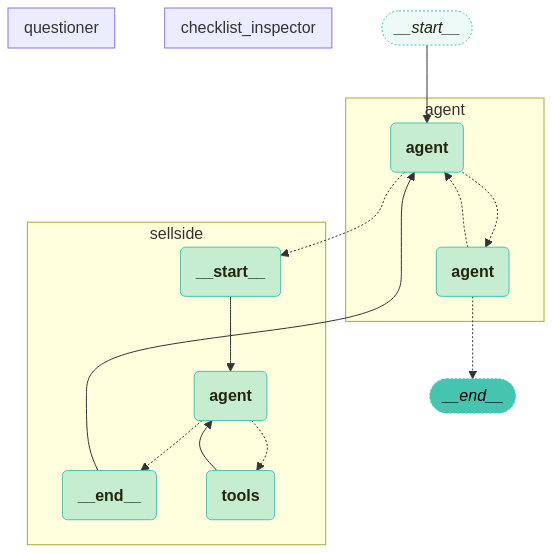

In [29]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

In [30]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph
from langchain_core.messages import HumanMessage

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 초기 상태 설정
inputs = {
    "messages": [],
    "score": {},
    "comment": {},
    "sender": "",
}

invoke_graph(app, inputs, config)


🔄 Node: agent in [questioner] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

업스테이지의 업종은 무엇인가요?

업스테이지의 기업가치(EV)는 얼마인가요?

업스테이지의 연매출은 얼마인가요?

업스테이지의 투자단계는 무엇인가요? (예: 초기, 성장, 성숙 등)

업스테이지의 최근 3년간 연평균 성장률은 얼마인가요?

업스테이지의 누적 투자유치금액은 얼마인가요?

업스테이지의 투자유치 건수는 몇 건인가요?

업스테이지의 수익성 등급은 어떻게 되나요? (예: A, B, C 등)

업스테이지의 자산 규모는 얼마인가요?

업스테이지의 기술 등급은 어떻게 되나요? (예: A, B, C 등)

업스테이지의 부채비율은 얼마인가요?

업스테이지의 영업이익률은 얼마인가요?

업스테이지의 순이익률은 얼마인가요?

업스테이지의 자산증가율은 얼마인가요?

🔄 Node: questioner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Name: questioner

업스테이지의 업종은 무엇인가요?

업스테이지의 기업가치(EV)는 얼마인가요?

업스테이지의 연매출은 얼마인가요?

업스테이지의 투자단계는 무엇인가요? (예: 초기, 성장, 성숙 등)

업스테이지의 최근 3년간 연평균 성장률은 얼마인가요?

업스테이지의 누적 투자유치금액은 얼마인가요?

업스테이지의 투자유치 건수는 몇 건인가요?

업스테이지의 수익성 등급은 어떻게 되나요? (예: A, B, C 등)

업스테이지의 자산 규모는 얼마인가요?

업스테이지의 기술 등급은 어떻게 되나요? (예: A, B, C 등)

업스테이지